## base data

- catchment and weather service climate stations
- coordinates in 3301 and 4326

In [1]:
import geopandas as gpd

stations = gpd.read_file('Estonia_ilmateenistus_3301_update3.gpkg', driver='GPKG', layer='all_stations')
stations.sample()

,station_name,ascii_name,wmocode,web_id,s_type,s_class,longitude,latitude,info_url,geometry
94,Kulgu hüdromeetriajaam,kulgu_sadam,41905,station_100,station_hydro_hj,122.0,28.173888888222223,59.34444444411111,https://www.ilmateenistus.ee/ilmateenistus/vaa...,POINT (737342.544 6585871.779)


In [2]:
stations.crs

<Projected CRS: EPSG:3301>
Name: Estonian Coordinate System of 1997
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Estonia
- bounds: (20.37, 57.52, 28.2, 60.0)
Coordinate Operation:
- name: Estonian National Grid
- method: Lambert Conic Conformal (2SP)
Datum: Estonia 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [3]:
catchment = gpd.read_file(r'C:\dev\05_geodata\hydrological\catchments\joint_catchments_work\all_catchments_3301.shp')
catchment.crs

<Projected CRS: EPSG:3301>
Name: Estonian Coordinate System of 1997
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Estonia
- bounds: (20.37, 57.52, 28.2, 60.0)
Coordinate Operation:
- name: Estonian National Grid
- method: Lambert Conic Conformal (2SP)
Datum: Estonia 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

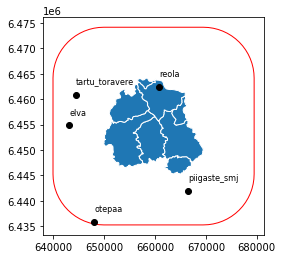

In [4]:
from shapely.geometry import shape, box, Polygon, Point

c = box(*list(catchment.total_bounds))
clip_geom = c.buffer(10000)

clip_gdf = gpd.GeoDataFrame({'geometry': [clip_geom]}, geometry = 'geometry', crs= 3301)

sub_stations = gpd.overlay(stations, clip_gdf, how='intersection')

import matplotlib.pyplot as plt

ax = clip_gdf.plot(facecolor='None', edgecolor='red')
catchment.plot(ax=ax, edgecolor='white', lw=1)
sub_stations.plot(color='black', ax=ax)
for idx, s in sub_stations.iterrows():
    plt.text(s['geometry'].x, s['geometry'].y,"{}\n".format(s['ascii_name']),size=8, color='black')

In [5]:
clip_gdf.to_crs(4326).total_bounds

# min_lon = 26.37499704
# min_lat = 58.02596472
# max_lon = 27.06062055
# max_lat = 58.38204428

min_lon, min_lat, max_lon, max_lat = tuple(clip_gdf.to_crs(4326).total_bounds)

## base metadata to find files and data structures

- initially single file acces, can try glob/multi-file access later

In [6]:
import os
import sys
import datetime

sat_base = r"R:\Des\satellite precipitation"


In [7]:
sat_data = {
    'CMORPH' : {
        'how': 'daily',
        'filepattern': os.path.join("YYYY", "CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_YYYYMMDD.nc"),
        'first': datetime.date(2007, 1, 1),
        'last': datetime.date(2020, 12, 31),
        'variable': 'cmorph(time, lat, lon)'
    },
    'CMORPH-CRT' : {
        'how': 'daily',
        'filepattern': os.path.join("YYYY", '500727.cmorph.CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_YYYYMMDD.nc'),
        'first': datetime.date(2007, 1, 1),
        'last': datetime.date(2020, 12, 31),
        'variable': 'cmorph(time, lat, lon)'
    },
    'PERSIANN-CDR' : {
        'how': 'yearly',
        'filepattern': 'CDR_2021-07-11040515am_YYYY.nc',
        'first': datetime.date(2007, 1, 1),
        'last': datetime.date(2020, 12, 31),
        'variable': 'precip(datetime, lat, lon)'
    },
    'SM2RAIN-ASCAT': {
        'how': 'yearly',
        'filepattern' : 'SM2RAIN_ASCAT_0125_YYYY_v1.1.nc',
        'first': datetime.date(2007, 1, 1),
        'last': datetime.date(2019, 12, 31),
        'variable': 'Rainfall(locations, time)'
    },
    'SM2RAIN-ASCAT_V_1.4': {
        'how': 'yearly',
        'filepattern' : 'SM2RAIN_ASCAT_0125_YYYY_v1.4.nc',
        'first': datetime.date(2007, 1, 1),
        'last': datetime.date(2020, 12, 31),
        'variable': 'Rainfall(Latitude, Longitude, time)'
    },
    'IMERG' : {
        'how': 'daily',
        'filepattern': os.path.join("YYYY", '3B-DAY.MS.MRG.3IMERG.YYYYMMDD-S000000-E235959.V06.nc4'),
        'first': datetime.date(2007, 1, 1),
        'last': datetime.date(2020, 12, 31),
        'variable': 'precipitationCal(time, lon, lat)'
    },
    'ERA5' : {
        'how': 'daily',
        'filepattern': os.path.join("YYYY", 'gpcp_v01r03_daily_dYYYYMMDD.nc'),
        'first': datetime.date(2007, 1, 1),
        'last': datetime.date(2020, 12, 31),
        'variable': 'precip(time, latitude, longitude)'
    }
}

In [8]:
import glob
import dask
from dask.distributed import Client
import xarray as xr
import pandas as pd
import numpy as np

In [9]:
def set_date_string(fp, dt):
    year, month, day = dt.year, dt.month, dt.day
    return fp.replace('YYYY', str(year)).replace('MM', str(month).zfill(2)).replace('DD', str(day).zfill(2))

In [10]:
def set_date_string_wglob(fp, dt, glob_str=''):
    year, month, day = dt.year, dt.month, dt.day
    tmp = fp
    if len(glob_str) > 0:
        tmp = tmp.replace(glob_str, '*')
    return tmp.replace('YYYY', str(year)).replace('MM', str(month).zfill(2)).replace('DD', str(day).zfill(2))

In [11]:
for i in sat_data.keys():
    print(i)
    first = sat_data[i]['first']
    fp = sat_data[i]['filepattern']
    f1 = os.path.join(sat_base,  i, set_date_string(fp, first) )
    print(f1)
    print(os.path.isfile(f1))
    ds = xr.open_dataset(f1)
    print(ds.info())

CMORPH
R:\Des\satellite precipitation\CMORPH\2007\CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_20070101.nc
True
xarray.Dataset {
dimensions:
	lat = 480 ;
	lon = 1440 ;
	nv = 2 ;
	time = 1 ;

variables:
	datetime64[ns] time(time) ;
		time:standard_name = time ;
		time:long_name = starting point of time period ;
		time:axis = T ;
		time:bounds = time_bounds ;
	datetime64[ns] time_bounds(time, nv) ;
		time_bounds:comment = time bounds for each time value ;
	float32 lat(lat) ;
		lat:standard_name = latitude ;
		lat:long_name = latitude of center of grid box ;
		lat:units = degrees_north ;
		lat:axis = Y ;
		lat:valid_min = -59.875 ;
		lat:valid_max = 59.875 ;
		lat:bounds = lat_bounds ;
	float32 lat_bounds(lat, nv) ;
		lat_bounds:units = degrees_north ;
		lat_bounds:comment = latitude values at south and north bounds of grid box ;
	float32 lon(lon) ;
		lon:standard_name = longitude ;
		lon:long_name = longitude of center of grid box ;
		lon:units = degrees_east ;
		lon:axis = X ;
		lon:valid_min = 0.12

## CMORPH lat lon time indexed data selection

- CMORPH, CMORPH-CRT and PERSIANN are time/datetim, lat, lon indexed as a grid

In [12]:
ds = xr.open_dataset(r"R:\Des\satellite precipitation\CMORPH\2007\CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_20070101.nc")

In [13]:
ds

<xarray.Dataset>
Dimensions:      (lat: 480, lon: 1440, nv: 2, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 2007-01-01
  * lat          (lat) float32 -59.875 -59.625 -59.375 ... 59.375 59.625 59.875
  * lon          (lon) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
Dimensions without coordinates: nv
Data variables:
    time_bounds  (time, nv) datetime64[ns] ...
    lat_bounds   (lat, nv) float32 ...
    lon_bounds   (lon, nv) float32 ...
    cmorph       (time, lat, lon) float32 ...
Attributes:
    ncei_template_version:      NCEI_NetCDF_Grid_template_V2.0
    title:                      NOAA Climate Data Record (CDR) of CPC Morphin...
    keywords:                   Precipitation, Satellite, High-Resolution, Gl...
    summary:                    The CMORPH CDR is a reprocessed and bias-corr...
    references:                 Xie, P., et al. (2017), Reprocessed, Bias-Cor...
    Conventions:                CF-1.6, ACDD-1.3
    naming_authority:           gov.noaa.ncei
    history:                    Version 1.0 release in August 2015
    source:                     Passive Microwave (PMW) Level 2 precipitation...
    license:                    No constraints on data access or use.
    cdr_program:                NOAA/NESDIS Climate Data Record Program
    cdr_variable:               precipitation
    product_version:            Version 1.0
    cdm_data_type:              Grid
    project:                    Climate Data Record for CMORPH High-Resolutio...
    institution:                DOC/NOAA/NWS/NCEP/CPC > Climate Prediction Ce...
    contributor_name:           Pingping Xie; Robert Joyce; Shaorong Wu
    contributor_role:           Project Leader; Co-Investigator; Co-Investigator
    creator_name:               Dr. Pingping Xie
    creator_email:              pingping.xie@noaa.gov
    creator_type:               group
    creator_institution:        DOC/NOAA/NWS/NCEP/CPC > Climate Prediction Ce...
    creator_url:                http://www.cpc.noaa.gov/
    comment:                    Please contact Pingping Xie (pingping.xie@noa...
    acknowledgement:            This project was supported in part by a grant...
    standard_name_vocabulary:   CF Standard Name Table (v47, 19 September 2017)
    publisher_name:             NOAA National Centers for Environmental Infor...
    publisher_email:            ncei.orders@noaa.gov
    publisher_type:             institution
    publisher_institution:      NOAA National Centers for Environmental Infor...
    publisher_url:              http://www.ncei.noaa.gov
    program:                    NOAA Climate Data Record Program
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Ea...
    platform:                   DMSP 5D-2/F13, DMSP 5D-2/F14, DMSP 5D-3/F15, ...
    platform_vocabulary:        NASA Global Change Master Directory (GCMD) Pl...
    instrument:                 SSM/I, AMSU-B, AMSR-E, TMI, MHS, MWRI
    instrument_vocabulary:      NASA Global Change Master Directory (GCMD) In...
    metadata_link:              gov.noaa.ncdc:C00948
    processing_level:           NOAA Level 3
    uuid:                       b7289322-a553-11e8-9075-90b11c64af79
    id:                         CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_20070101.nc
    date_created:               2018-08-21
    date_modified:              2018-08-21
    date_issued:                2018-08-21
    time_coverage_start:        2007-01-01T00:00:00Z
    time_coverage_end:          2007-01-01T23:59:59Z
    time_coverage_duration:     P1D
    time_coverage_resolution:   P1D
    spatial_resolution:         0.25x0.25 deg lat/lon
    geospatial_lat_min:         -60.0
    geospatial_lat_max:         60.0
    geospatial_lat_resolution:  0.25
    geospatial_lat_units:       degrees_north
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lon_resolution:  0.25
    geospatial_lon_units:       degrees_east

In [14]:
sub_stations

,station_name,ascii_name,wmocode,web_id,s_type,s_class,longitude,latitude,info_url,geometry
0,Tartu-Tõravere meteoroloogiajaam,tartu_toravere,26242,station_61,station_meteo_mj,111.0,26.46130555576748,58.264072222179834,https://www.ilmateenistus.ee/ilmateenistus/vaa...,POINT (644432.406 6460796.729)
1,Piigaste sademete mõõtejaam,piigaste_smj,41062,station_89,station_meteo_smj,113.0,26.82444444377778,58.087777777444444,https://www.ilmateenistus.ee/ilmateenistus/vaa...,POINT (666556.594 6442018.495)
2,Reola hüdromeetriajaam,reola,41184,station_91,station_hydro_hj,122.0,26.741944444111112,58.27333333266667,https://www.ilmateenistus.ee/ilmateenistus/vaa...,POINT (660849.781 6462466.058)
3,Elva hüdromeetriajaam,elva,41058,station_23,station_hydro_hj,122.0,26.43444444411111,58.21138888888889,https://www.ilmateenistus.ee/ilmateenistus/vaa...,POINT (643069.771 6454875.335)
4,Otepää sademete mõõtejaam,otepaa,None,station_19,station_meteo_smj,113.0,26.50656944433848,58.03926111082016,https://www.ilmateenistus.ee/ilmateenistus/vaa...,POINT (648022.765 6435873.698)


In [15]:
mask_lon = (ds.lon >= min_lon) & (ds.lon <= max_lon)
mask_lat = (ds.lat >= min_lat) & (ds.lat <= max_lat)

In [16]:
cropped_ds = ds.where(mask_lon & mask_lat, drop=True)

In [17]:
cropped_ds

<xarray.Dataset>
Dimensions:      (lat: 2, lon: 3, nv: 2, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 2007-01-01
  * lat          (lat) float32 58.125 58.375
  * lon          (lon) float32 26.375 26.625 26.875
Dimensions without coordinates: nv
Data variables:
    time_bounds  (time, nv, lon, lat) datetime64[ns] 2007-01-01 ... 2007-01-0...
    lat_bounds   (lat, nv, lon) float32 58.0 58.0 58.0 58.25 ... 58.5 58.5 58.5
    lon_bounds   (lon, nv, lat) float32 26.25 26.25 26.5 ... 26.75 27.0 27.0
    cmorph       (time, lat, lon) float32 1.8000001 0.90000004 ... 7.3 4.9
Attributes:
    ncei_template_version:      NCEI_NetCDF_Grid_template_V2.0
    title:                      NOAA Climate Data Record (CDR) of CPC Morphin...
    keywords:                   Precipitation, Satellite, High-Resolution, Gl...
    summary:                    The CMORPH CDR is a reprocessed and bias-corr...
    references:                 Xie, P., et al. (2017), Reprocessed, Bias-Cor...
    Conventions:                CF-1.6, ACDD-1.3
    naming_authority:           gov.noaa.ncei
    history:                    Version 1.0 release in August 2015
    source:                     Passive Microwave (PMW) Level 2 precipitation...
    license:                    No constraints on data access or use.
    cdr_program:                NOAA/NESDIS Climate Data Record Program
    cdr_variable:               precipitation
    product_version:            Version 1.0
    cdm_data_type:              Grid
    project:                    Climate Data Record for CMORPH High-Resolutio...
    institution:                DOC/NOAA/NWS/NCEP/CPC > Climate Prediction Ce...
    contributor_name:           Pingping Xie; Robert Joyce; Shaorong Wu
    contributor_role:           Project Leader; Co-Investigator; Co-Investigator
    creator_name:               Dr. Pingping Xie
    creator_email:              pingping.xie@noaa.gov
    creator_type:               group
    creator_institution:        DOC/NOAA/NWS/NCEP/CPC > Climate Prediction Ce...
    creator_url:                http://www.cpc.noaa.gov/
    comment:                    Please contact Pingping Xie (pingping.xie@noa...
    acknowledgement:            This project was supported in part by a grant...
    standard_name_vocabulary:   CF Standard Name Table (v47, 19 September 2017)
    publisher_name:             NOAA National Centers for Environmental Infor...
    publisher_email:            ncei.orders@noaa.gov
    publisher_type:             institution
    publisher_institution:      NOAA National Centers for Environmental Infor...
    publisher_url:              http://www.ncei.noaa.gov
    program:                    NOAA Climate Data Record Program
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Ea...
    platform:                   DMSP 5D-2/F13, DMSP 5D-2/F14, DMSP 5D-3/F15, ...
    platform_vocabulary:        NASA Global Change Master Directory (GCMD) Pl...
    instrument:                 SSM/I, AMSU-B, AMSR-E, TMI, MHS, MWRI
    instrument_vocabulary:      NASA Global Change Master Directory (GCMD) In...
    metadata_link:              gov.noaa.ncdc:C00948
    processing_level:           NOAA Level 3
    uuid:                       b7289322-a553-11e8-9075-90b11c64af79
    id:                         CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_20070101.nc
    date_created:               2018-08-21
    date_modified:              2018-08-21
    date_issued:                2018-08-21
    time_coverage_start:        2007-01-01T00:00:00Z
    time_coverage_end:          2007-01-01T23:59:59Z
    time_coverage_duration:     P1D
    time_coverage_resolution:   P1D
    spatial_resolution:         0.25x0.25 deg lat/lon
    geospatial_lat_min:         -60.0
    geospatial_lat_max:         60.0
    geospatial_lat_resolution:  0.25
    geospatial_lat_units:       degrees_north
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lon_resolution:  0.25
    geospatial

In [18]:
ds.cmorph.sel(lat=58.125, lon=26.375, time='2007-01-01')

<xarray.DataArray 'cmorph' ()>
array(1.8, dtype=float32)
Coordinates:
    time     datetime64[ns] 2007-01-01
    lat      float32 58.125
    lon      float32 26.375
Attributes:
    standard_name:  lwe_precipitation_rate
    long_name:      NOAA Climate Data Record (CDR) of CPC Morphing Technique ...
    units:          mm/day
    valid_min:      0
    valid_max:      32767
    comment:        !!! CMORPH estimate is rainrate !!!

In [19]:
ds.cmorph.sel(lat=58.264, lon=26.461, method="nearest" , time='2007-01-01')

<xarray.DataArray 'cmorph' ()>
array(7.4, dtype=float32)
Coordinates:
    time     datetime64[ns] 2007-01-01
    lat      float32 58.375
    lon      float32 26.375
Attributes:
    standard_name:  lwe_precipitation_rate
    long_name:      NOAA Climate Data Record (CDR) of CPC Morphing Technique ...
    units:          mm/day
    valid_min:      0
    valid_max:      32767
    comment:        !!! CMORPH estimate is rainrate !!!

In [20]:
cropped_ds.sel(time='2007-01-01').lat.data
lats = cropped_ds.sel(time='2007-01-01').lat.data
lons = cropped_ds.sel(time='2007-01-01').lon.data

x = np.array([[x0, y0] for x0 in lons for y0 in lats])[:,0]
y = np.array([[x0, y0] for x0 in lons for y0 in lats])[:,1]

cmorph_stations = pd.DataFrame({'station': range(6), 'lon': x, 'lat': y})
cmorph_stations['geometry'] = cmorph_stations.apply(lambda x: Point(x['lon'], x['lat']), axis=1)
cmorph_stations = gpd.GeoDataFrame(cmorph_stations, geometry='geometry', crs=4326)
cmorph_stations

,station,lon,lat,geometry
0,0,26.375,58.125,POINT (26.37500 58.12500)
1,1,26.375,58.375,POINT (26.37500 58.37500)
2,2,26.625,58.125,POINT (26.62500 58.12500)
3,3,26.625,58.375,POINT (26.62500 58.37500)
4,4,26.875,58.125,POINT (26.87500 58.12500)
5,5,26.875,58.375,POINT (26.87500 58.37500)


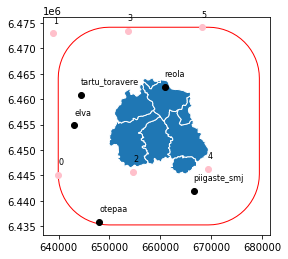

In [21]:
ax = clip_gdf.plot(facecolor='None', edgecolor='red')
catchment.plot(ax=ax, edgecolor='white', lw=1)
sub_stations.plot(color='black', ax=ax)
for idx, s in sub_stations.iterrows():
    plt.text(s['geometry'].x, s['geometry'].y,"{}\n".format(s['ascii_name']),size=8, color='black')
cmorph_stations.to_crs(3301).plot(color='pink', ax=ax)
for idx, s in cmorph_stations.to_crs(3301).iterrows():
    plt.text(s['geometry'].x, s['geometry'].y,"{}\n".format(s['station']),size=8, color='black')

### now trying to load whole year of CMORPH and do extraction of timeseries at the stations only

In [31]:
sat_data['CMORPH']

{'how': 'daily',
 'filepattern': 'YYYY\\CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_YYYYMMDD.nc',
 'first': datetime.date(2007, 1, 1),
 'last': datetime.date(2020, 12, 31),
 'variable': 'cmorph(time, lat, lon)'}

In [32]:
%%time

first = sat_data['CMORPH']['first']
fp = sat_data['CMORPH']['filepattern']
f1 = os.path.join(sat_base,  'CMORPH', set_date_string_wglob(fp, first, glob_str='YYYYMMDD') )
print(f1)

ds = xr.open_mfdataset(f1)

R:\Des\satellite precipitation\CMORPH\2007\CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_*.nc
Wall time: 13 s


In [33]:
ds

,Array,Chunk
Bytes,5.84 kB,16 B
Shape,"(365, 2)","(1, 2)"
Count,1095 Tasks,365 Chunks
Type,datetime64[ns],numpy.ndarray
,Array,Chunk
Bytes,1.40 MB,3.84 kB
Shape,"(365, 480, 2)","(1, 480, 2)"
Count,1460 Tasks,365 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


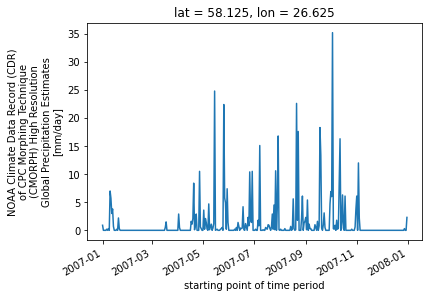

In [34]:
ds.cmorph.sel(lat=58.125, lon=26.625).plot()

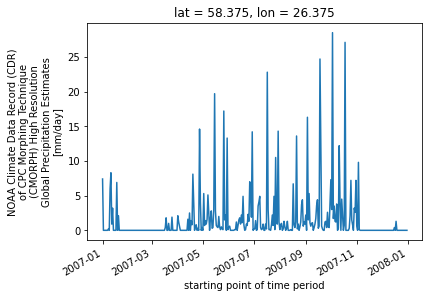

In [35]:
ds.cmorph.sel(lat=58.264072222179834, lon=26.46130555576748, method='nearest').plot()

In [36]:
catch_it = []

for idx, row in cmorph_stations.iterrows():
    ts = ds.cmorph.sel(lat=row['lat'], lon=row['lon'])
    df = ts.to_dataframe()
    catch_it.append( df.drop(columns=['lon', 'lat']).rename(columns={ 'cmorph': f"cmorph_{row['lat']}_{row['lon']}" } ) )
    # ts.plot()
    
for idx, row in sub_stations.iterrows():
    ts = ds.cmorph.sel(lat=row['latitude'], lon=row['longitude'], method='nearest')
    df = ts.to_dataframe()
    catch_it.append( df.drop(columns=['lon', 'lat']).rename(columns={ 'cmorph': row['ascii_name'] } ) )
    # ts.plot()



<AxesSubplot:xlabel='time'>

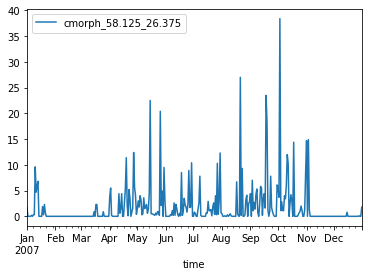

In [37]:
catch_it[0].plot()

<AxesSubplot:xlabel='time'>

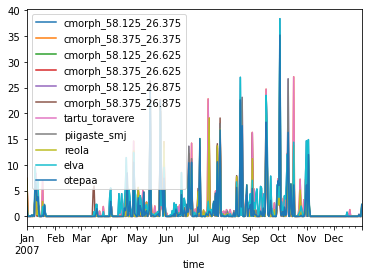

In [38]:
cmorph_df_2007 = pd.concat(catch_it, axis=1)
cmorph_df_2007.plot()

### now for all years of CMORPH

In [ ]:
first = sat_data['CMORPH']['first']
last = sat_data['CMORPH']['last']

annual_dfs = []

for yy in range(first.year, last.year+1):
    print(yy)
    fp = sat_data['CMORPH']['filepattern']
    f1 = os.path.join(sat_base,  'CMORPH', set_date_string_wglob(fp, datetime.date(yy, 1, 1), glob_str='YYYYMMDD') )
    print(f1)
    
    ds = xr.open_mfdataset(f1)

    catch_it = []

    for idx, row in cmorph_stations.iterrows():
        ts = ds.cmorph.sel(lat=row['lat'], lon=row['lon'])
        df = ts.to_dataframe()
        catch_it.append( df.drop(columns=['lon', 'lat']).rename(columns={ 'cmorph': f"cmorph_{row['lat']}_{row['lon']}" } ) )

    for idx, row in sub_stations.iterrows():
        ts = ds.cmorph.sel(lat=row['latitude'], lon=row['longitude'], method='nearest')
        df = ts.to_dataframe()
        catch_it.append( df.drop(columns=['lon', 'lat']).rename(columns={ 'cmorph': row['ascii_name'] } ) )

    cmorph_df_year = pd.concat(catch_it, axis=1)
    annual_dfs.append(cmorph_df_year)
    

In [ ]:
cmorph_df_year.plot()

In [ ]:
cmorph_df_all = pd.concat(annual_dfs, axis=0)

In [ ]:
out_dir = 'CMORPH'
out_file = 'CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_extracted.csv'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

cmorph_df_all.to_csv(os.path.join(out_dir, out_file) )

cmorph_stations.to_file(os.path.join(out_dir, 'cmorph_stations.shp') )

In [ ]:
cmorph_df_all.plot()

## CMORPH-CRT

In [39]:
sat_data['CMORPH-CRT']

{'how': 'daily',
 'filepattern': 'YYYY\\500727.cmorph.CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_YYYYMMDD.nc',
 'first': datetime.date(2007, 1, 1),
 'last': datetime.date(2020, 12, 31),
 'variable': 'cmorph(time, lat, lon)'}

In [40]:
ds = xr.open_dataset(r"R:\Des\satellite precipitation\CMORPH-CRT\2007\500727.cmorph.CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_20070101.nc")

In [41]:
ds

<xarray.Dataset>
Dimensions:      (lat: 8, lon: 12, nv: 2, time: 1)
Coordinates:
  * lat          (lat) float32 57.125 57.375 57.625 ... 58.375 58.625 58.875
  * lon          (lon) float32 25.125 25.375 25.625 ... 27.375 27.625 27.875
  * time         (time) datetime64[ns] 2007-01-01
Dimensions without coordinates: nv
Data variables:
    cmorph       (time, lat, lon) float32 ...
    lat_bounds   (lat, nv) float32 ...
    lon_bounds   (lon, nv) float32 ...
    time_bounds  (time, nv) datetime64[ns] ...
Attributes:
    ncei_template_version:      NCEI_NetCDF_Grid_template_V2.0
    title:                      NOAA Climate Data Record (CDR) of CPC Morphin...
    keywords:                   Precipitation, Satellite, High-Resolution, Gl...
    summary:                    The CMORPH CDR is a reprocessed and bias-corr...
    references:                 Xie, P., et al. (2017), Reprocessed, Bias-Cor...
    Conventions:                CF-1.6, ACDD-1.3
    naming_authority:           gov.noaa.ncei
    history:                    Mon Jul 12 10:56:18 2021: ncks -d lat,57.0,59...
    source:                     Passive Microwave (PMW) Level 2 precipitation...
    license:                    No constraints on data access or use.
    cdr_program:                NOAA/NESDIS Climate Data Record Program
    cdr_variable:               precipitation
    product_version:            Version 1.0
    cdm_data_type:              Grid
    project:                    Climate Data Record for CMORPH High-Resolutio...
    institution:                DOC/NOAA/NWS/NCEP/CPC > Climate Prediction Ce...
    contributor_name:           Pingping Xie; Robert Joyce; Shaorong Wu
    contributor_role:           Project Leader; Co-Investigator; Co-Investigator
    creator_name:               Dr. Pingping Xie
    creator_email:              pingping.xie@noaa.gov
    creator_type:               group
    creator_institution:        DOC/NOAA/NWS/NCEP/CPC > Climate Prediction Ce...
    creator_url:                http://www.cpc.noaa.gov/
    comment:                    Please contact Pingping Xie (pingping.xie@noa...
    acknowledgement:            This project was supported in part by a grant...
    standard_name_vocabulary:   CF Standard Name Table (v47, 19 September 2017)
    publisher_name:             NOAA National Centers for Environmental Infor...
    publisher_email:            ncei.orders@noaa.gov
    publisher_type:             institution
    publisher_institution:      NOAA National Centers for Environmental Infor...
    publisher_url:              http://www.ncei.noaa.gov
    program:                    NOAA Climate Data Record Program
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Ea...
    platform:                   DMSP 5D-2/F13, DMSP 5D-2/F14, DMSP 5D-3/F15, ...
    platform_vocabulary:        NASA Global Change Master Directory (GCMD) Pl...
    instrument:                 SSM/I, AMSU-B, AMSR-E, TMI, MHS, MWRI
    instrument_vocabulary:      NASA Global Change Master Directory (GCMD) In...
    metadata_link:              gov.noaa.ncdc:C00948
    processing_level:           NOAA Level 3
    uuid:                       b7289322-a553-11e8-9075-90b11c64af79
    id:                         CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_20070101.nc
    date_created:               2018-08-21
    date_modified:              2018-08-21
    date_issued:                2018-08-21
    time_coverage_start:        2007-01-01T00:00:00Z
    time_coverage_end:          2007-01-01T23:59:59Z
    time_coverage_duration:     P1D
    time_coverage_resolution:   P1D
    spatial_resolution:         0.25x0.25 deg lat/lon
    geospatial_lat_min:         -60.0
    geospatial_lat_max:         60.0
    geospatial_lat_resolution:  0.25
    geospatial_lat_units:       degrees_north
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lon_resolution:  0.25
    geospatial_lon_units:       degrees_east
    NCO:                        netCDF 

In [42]:
from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress

# dclient = Client(n_workers=4)
# client.close()

In [48]:
%%time

# looks very similar to CMORPH structure, assuming also same stations "cmorph_stations"

data_select = 'CMORPH-CRT'
first = sat_data[data_select]['first']
last = sat_data[data_select]['last']

annual_dfs = []

for yy in range(first.year, last.year+1):
    with ProgressBar():
        print(yy)
        fp = sat_data[data_select]['filepattern']
        f1 = os.path.join(sat_base,  data_select, set_date_string_wglob(fp, datetime.date(yy, 1, 1), glob_str='YYYYMMDD') )
        print(f1)

        ds = xr.open_mfdataset(f1, parallel=True).load()

        catch_it = []

        for idx, row in cmorph_stations.iterrows():
            ts = ds.cmorph.sel(lat=row['lat'], lon=row['lon'])
            df = ts.to_dataframe()
            catch_it.append( df.drop(columns=['lon', 'lat']).rename(columns={ 'cmorph': f"cmorph_{row['lat']}_{row['lon']}" } ) )

        for idx, row in sub_stations.iterrows():
            ts = ds.cmorph.sel(lat=row['latitude'], lon=row['longitude'], method='nearest')
            df = ts.to_dataframe()
            catch_it.append( df.drop(columns=['lon', 'lat']).rename(columns={ 'cmorph': row['ascii_name'] } ) )

    cmorph_df_year = pd.concat(catch_it, axis=1)
    annual_dfs.append(cmorph_df_year)


2007
R:\Des\satellite precipitation\CMORPH-CRT\2007\500727.cmorph.CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_*.nc
2008
R:\Des\satellite precipitation\CMORPH-CRT\2008\500727.cmorph.CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_*.nc
2009
R:\Des\satellite precipitation\CMORPH-CRT\2009\500727.cmorph.CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_*.nc
2010
R:\Des\satellite precipitation\CMORPH-CRT\2010\500727.cmorph.CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_*.nc
2011
R:\Des\satellite precipitation\CMORPH-CRT\2011\500727.cmorph.CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_*.nc
2012
R:\Des\satellite precipitation\CMORPH-CRT\2012\500727.cmorph.CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_*.nc
2013
R:\Des\satellite precipitation\CMORPH-CRT\2013\500727.cmorph.CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_*.nc
2014
R:\Des\satellite precipitation\CMORPH-CRT\2014\500727.cmorph.CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_*.nc
2015
R:\Des\satellite precipitation\CMORPH-CRT\2015\500727.cmorph.CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_*.nc
2016
R:\Des\satellite precipitation\CMORPH-CRT\2016\500727.cmorph.CMORPH_

In [49]:
cmorph_df_all = pd.concat(annual_dfs, axis=0)

In [50]:
out_dir = data_select
out_file = '500727.cmorph.CMORPH_V1.0_ADJ_0.25deg-DLY_00Z_extracted.csv'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

cmorph_df_all.to_csv(os.path.join(out_dir, out_file) )

cmorph_stations.to_file(os.path.join(out_dir, 'cmorph_stations.shp') )

<AxesSubplot:xlabel='time'>

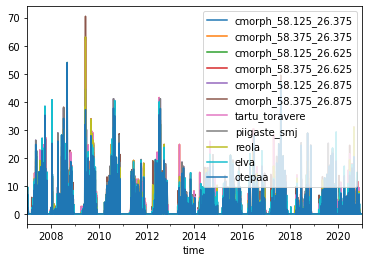

In [51]:
cmorph_df_all.plot()

## PERSIANN-CDR

- also time lat lon
- yearly, so only a few files actually

In [83]:
data_select = 'PERSIANN-CDR'

sat_data[data_select]

{'how': 'yearly',
 'filepattern': 'CDR_2021-07-11040515am_YYYY.nc',
 'first': datetime.date(2007, 1, 1),
 'last': datetime.date(2020, 12, 31),
 'variable': 'precip(datetime, lat, lon)'}

In [84]:
first = sat_data[data_select]['first']
fp = sat_data[data_select]['filepattern']
f1 = os.path.join(sat_base,  data_select, set_date_string(fp, first) )
print(f1)

ds = xr.open_dataset(f1)

R:\Des\satellite precipitation\PERSIANN-CDR\CDR_2021-07-11040515am_2007.nc


In [85]:
ds

<xarray.Dataset>
Dimensions:   (datetime: 365, lat: 4, lon: 11)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * lon       (lon) float32 25.0 25.25 25.5 25.75 26.0 ... 26.75 27.0 27.25 27.5
  * lat       (lat) float32 58.5 58.25 58.0 57.75
Data variables:
    crs       int32 ...
    precip    (datetime, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6

In [86]:
# firs twe need the stations, they are likely different
mask_lon = (ds.lon >= min_lon-0.1) & (ds.lon <= max_lon+0.1)
mask_lat = (ds.lat >= min_lat-0.1) & (ds.lat <= max_lat+0.1)

cropped_ds = ds.where(mask_lon & mask_lat, drop=True)
cropped_ds

<xarray.Dataset>
Dimensions:   (datetime: 365, lat: 2, lon: 3)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2007-01-01 2007-01-02 ... 2007-12-31
  * lon       (lon) float32 26.5 26.75 27.0
  * lat       (lat) float32 58.25 58.0
Data variables:
    crs       (lon, lat) float64 -2.147e+09 -2.147e+09 ... -2.147e+09 -2.147e+09
    precip    (datetime, lat, lon) float32 16.89 14.46 14.09 ... 1.56 0.7 0.0
Attributes:
    Conventions:  CF-1.6

In [87]:
cropped_ds.sel(datetime='2007-01-01').lat.data
lats = cropped_ds.sel(datetime='2007-01-01').lat.data
lons = cropped_ds.sel(datetime='2007-01-01').lon.data

x = np.array([[x0, y0] for x0 in lons for y0 in lats])[:,0]
y = np.array([[x0, y0] for x0 in lons for y0 in lats])[:,1]

persiann_stations = pd.DataFrame({'station': range(len(x)), 'lon': x, 'lat': y})
persiann_stations['geometry'] = persiann_stations.apply(lambda x: Point(x['lon'], x['lat']), axis=1)
persiann_stations = gpd.GeoDataFrame(persiann_stations, geometry='geometry', crs=4326)
persiann_stations

,station,lon,lat,geometry
0,0,26.50,58.25,POINT (26.50000 58.25000)
1,1,26.50,58.00,POINT (26.50000 58.00000)
2,2,26.75,58.25,POINT (26.75000 58.25000)
3,3,26.75,58.00,POINT (26.75000 58.00000)
4,4,27.00,58.25,POINT (27.00000 58.25000)
5,5,27.00,58.00,POINT (27.00000 58.00000)


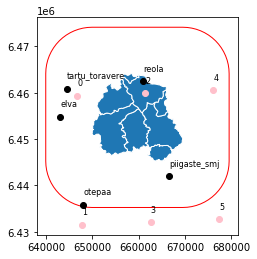

In [88]:
ax = clip_gdf.plot(facecolor='None', edgecolor='red')
catchment.plot(ax=ax, edgecolor='white', lw=1)
sub_stations.plot(color='black', ax=ax)
for idx, s in sub_stations.iterrows():
    plt.text(s['geometry'].x, s['geometry'].y,"{}\n".format(s['ascii_name']),size=8, color='black')
persiann_stations.to_crs(3301).plot(color='pink', ax=ax)
for idx, s in persiann_stations.to_crs(3301).iterrows():
    plt.text(s['geometry'].x, s['geometry'].y,"{}\n".format(s['station']),size=8, color='black')

In [89]:
first = sat_data[data_select]['first']
last = sat_data[data_select]['last']

annual_dfs = []

for yy in range(first.year, last.year+1):
    print(yy)
    fp = sat_data[data_select]['filepattern']
    f1 = os.path.join(sat_base,  data_select, set_date_string(fp, datetime.date(yy, 1, 1)) )
    print(f1)
    
    ds = xr.open_mfdataset(f1)

    catch_it = []

    for idx, row in persiann_stations.iterrows():
        ts = ds.precip.sel(lat=row['lat'], lon=row['lon'])
        df = ts.to_dataframe()
        catch_it.append( df.drop(columns=['lon', 'lat']).rename(columns={ 'precip': f"persiann_{row['lat']}_{row['lon']}" } ) )

    for idx, row in sub_stations.iterrows():
        ts = ds.precip.sel(lat=row['latitude'], lon=row['longitude'], method='nearest')
        df = ts.to_dataframe()
        catch_it.append( df.drop(columns=['lon', 'lat']).rename(columns={ 'precip': row['ascii_name'] } ) )

    persiann_df_year = pd.concat(catch_it, axis=1)
    annual_dfs.append(persiann_df_year)

2007
R:\Des\satellite precipitation\PERSIANN-CDR\CDR_2021-07-11040515am_2007.nc
2008
R:\Des\satellite precipitation\PERSIANN-CDR\CDR_2021-07-11040515am_2008.nc
2009
R:\Des\satellite precipitation\PERSIANN-CDR\CDR_2021-07-11040515am_2009.nc
2010
R:\Des\satellite precipitation\PERSIANN-CDR\CDR_2021-07-11040515am_2010.nc
2011
R:\Des\satellite precipitation\PERSIANN-CDR\CDR_2021-07-11040515am_2011.nc
2012
R:\Des\satellite precipitation\PERSIANN-CDR\CDR_2021-07-11040515am_2012.nc
2013
R:\Des\satellite precipitation\PERSIANN-CDR\CDR_2021-07-11040515am_2013.nc
2014
R:\Des\satellite precipitation\PERSIANN-CDR\CDR_2021-07-11040515am_2014.nc
2015
R:\Des\satellite precipitation\PERSIANN-CDR\CDR_2021-07-11040515am_2015.nc
2016
R:\Des\satellite precipitation\PERSIANN-CDR\CDR_2021-07-11040515am_2016.nc
2017
R:\Des\satellite precipitation\PERSIANN-CDR\CDR_2021-07-11040515am_2017.nc
2018
R:\Des\satellite precipitation\PERSIANN-CDR\CDR_2021-07-11040515am_2018.nc
2019
R:\Des\satellite precipitation\PERS

In [90]:
persiann_df_all = pd.concat(annual_dfs, axis=0)

In [91]:
out_dir = data_select
out_file = 'CDR_2021-07-11040515am_extracted.csv'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

persiann_df_all.to_csv(os.path.join(out_dir, out_file) )

persiann_stations.to_file(os.path.join(out_dir, 'persiann_stations.shp') )

<AxesSubplot:xlabel='datetime'>

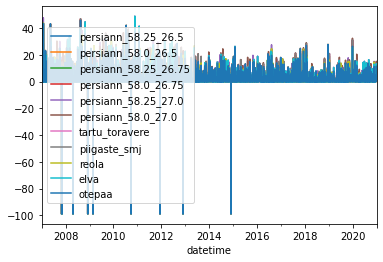

In [95]:
persiann_df_all.plot()

## SM2RAIN v1.1 location time indexed data selection

- SM2RAIN-ASCAT is indexed via station and time, so we need to select our desired station IDs first
- also the station coordinates are called Longitude and Latitude

In [77]:
data_select = 'SM2RAIN-ASCAT'

sat_data[data_select]

{'how': 'yearly',
 'filepattern': 'SM2RAIN_ASCAT_0125_YYYY_v1.1.nc',
 'first': datetime.date(2007, 1, 1),
 'last': datetime.date(2019, 12, 31),
 'variable': 'Rainfall(locations, time)'}

In [78]:
first = sat_data[data_select]['first']
fp = sat_data[data_select]['filepattern']
f1 = os.path.join(sat_base,  data_select, set_date_string(fp, first) )
print(f1)

ds = xr.open_dataset(f1)

R:\Des\satellite precipitation\SM2RAIN-ASCAT\SM2RAIN_ASCAT_0125_2007_v1.1.nc


In [79]:
ds

<xarray.Dataset>
Dimensions:    (locations: 839826, time: 365)
Dimensions without coordinates: locations, time
Data variables:
    Time       (time) datetime64[ns] ...
    Longitude  (locations) float32 ...
    Latitude   (locations) float32 ...
    Rainfall   (locations, time) float32 ...
    Conf_flag  (locations) int8 ...
    ssf        (locations, time) int8 ...
Attributes:
    title:                       ASCAT Soil moisture-derived rainfall using S...
    creation_time:               09-Sep-2019 15:37:20
    creator_institution:         National Research Council  - Research Instit...
    creator_institution_e-mail:   idrologia@irpi.cnr.it
    calibration:                 Two different calibration has been performed...
    correction:                  A climatological adjustment using model data...
    Temporal_interval:           Jan-01-2007 to Dec-31-2007
    version:                     1.1
    Acknowledgements:            Global SM2RAIN project (contract n.EUM/CO/17...

In [80]:
ds.locations

<xarray.DataArray 'locations' (locations: 839826)>
array([     0,      1,      2, ..., 839823, 839824, 839825], dtype=int64)
Dimensions without coordinates: locations

In [81]:
mask_lon = (ds.Longitude >= min_lon) & (ds.Longitude <= max_lon)
mask_lat = (ds.Latitude >= min_lat) & (ds.Latitude <= max_lat)

In [82]:
station_index = ds.locations.where(mask_lon & mask_lat, drop=True)
stat_ids = [int(i) for i in station_index.values]
stat_ids

[729661,
 729662,
 729663,
 730560,
 730561,
 730562,
 731458,
 731459,
 731460,
 731461]

In [83]:
ds.Rainfall.loc[729661, 2].data # or ds.Rainfall.loc[stat_ids, 2].data


array(2.4000001)

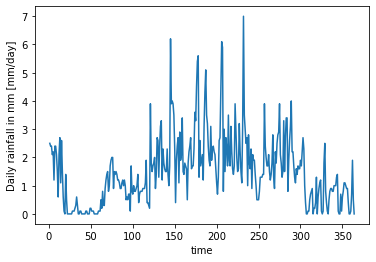

In [84]:
ds.Rainfall.sel(locations=729661).plot()

In [85]:
lats = ds.Latitude.loc[stat_ids]
lons = ds.Longitude.loc[stat_ids]

sm2rain_stations = pd.DataFrame({'station': stat_ids, 'lon': lons.data, 'lat': lats.data})
sm2rain_stations['geometry'] = sm2rain_stations.apply(lambda x: Point(x['lon'], x['lat']), axis=1)
sm2rain_stations = gpd.GeoDataFrame(sm2rain_stations, geometry='geometry', crs=4326)
sm2rain_stations

,station,lon,lat,geometry
0,729661,26.464973,58.056171,POINT (26.46497 58.05617)
1,729662,26.676693,58.056171,POINT (26.67669 58.05617)
2,729663,26.888414,58.056171,POINT (26.88841 58.05617)
3,730560,26.548271,58.168404,POINT (26.54827 58.16840)
4,730561,26.760656,58.168404,POINT (26.76066 58.16840)
5,730562,26.973043,58.168404,POINT (26.97304 58.16840)
6,731458,26.419140,58.280628,POINT (26.41914 58.28063)
7,731459,26.632196,58.280628,POINT (26.63220 58.28063)
8,731460,26.845255,58.280628,POINT (26.84525 58.28063)
9,731461,27.058311,58.280628,POINT (27.05831 58.28063)


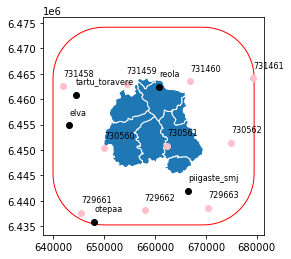

In [86]:
ax = clip_gdf.plot(facecolor='None', edgecolor='red')
catchment.plot(ax=ax, edgecolor='white', lw=1)
sub_stations.plot(color='black', ax=ax)
for idx, s in sub_stations.iterrows():
    plt.text(s['geometry'].x, s['geometry'].y,"{}\n".format(s['ascii_name']),size=8, color='black')
sm2rain_stations.to_crs(3301).plot(color='pink', ax=ax)
for idx, s in sm2rain_stations.to_crs(3301).iterrows():
    plt.text(s['geometry'].x, s['geometry'].y,"{}\n".format(s['station']),size=8, color='black')

In [87]:
# find nearest stations from SM2RAIN for our porijogi stations
# https://automating-gis-processes.github.io/CSC18/lessons/L4/nearest-neighbour.html

from shapely.ops import nearest_points
from shapely.geometry import MultiPoint

def nearest(row, geom_union, df1, df2, geom1_col='geometry', geom2_col='geometry', src_column=None):
    """Find the nearest point and return the corresponding value from specified column."""
    # Find the geometry that is closest
    nearest = df2[geom2_col] == nearest_points(row[geom1_col], geom_union)[1]
    # Get the corresponding value from df2 (matching is based on the geometry)
    value = df2[nearest][src_column].values[0]
    return value

In [88]:
unary_union = sm2rain_stations.to_crs(3301).unary_union

In [89]:
x2 = sub_stations.apply(nearest, geom_union=unary_union, df1=sub_stations, df2=sm2rain_stations.to_crs(3301), geom1_col='geometry', src_column='station', axis=1)
x1 = sub_stations['ascii_name']

In [93]:
match_df = pd.DataFrame({'est_station': x1, 'sm2rain_station': x2})
match_df

,est_station,sm2rain_station
0,tartu_toravere,731458
1,piigaste_smj,729663
2,reola,731460
3,elva,731458
4,otepaa,729661


In [94]:
first = sat_data[data_select]['first']
last = sat_data[data_select]['last']

annual_dfs = []

for yy in range(first.year, last.year+1):
    print(yy)
    fp = sat_data[data_select]['filepattern']
    f1 = os.path.join(sat_base,  data_select, set_date_string(fp, datetime.date(yy, 1, 1)) )
    print(f1)
    
    ds = xr.open_mfdataset(f1)

    catch_it = []

    for idx, row in sm2rain_stations.iterrows():
        ts = ds.Rainfall.sel(locations=int(row['station']))
        # df = ts.to_dataframe()
        t_idx = pd.date_range(start=f'{yy}-01-01', end=f'{yy}-12-31', freq="D")
        df = pd.DataFrame({'datetime': t_idx, 'data': ts}).set_index('datetime')
        catch_it.append( df.rename(columns={ 'data': f"sm2rain_{row['station']}" } ) )

    for idx, row in match_df.iterrows():
        ts = ds.Rainfall.sel(locations=int(row['sm2rain_station']))
        # df = ts.to_dataframe()
        t_idx = pd.date_range(start=f'{yy}-01-01', end=f'{yy}-12-31', freq="D")
        df = pd.DataFrame({'datetime': t_idx, 'data': ts}).set_index('datetime')
        catch_it.append( df.rename(columns={ 'data': row['est_station'] } ) )

    sm2rain_df_year = pd.concat(catch_it, axis=1)
    annual_dfs.append(sm2rain_df_year)

2007
R:\Des\satellite precipitation\SM2RAIN-ASCAT\SM2RAIN_ASCAT_0125_2007_v1.1.nc
2008
R:\Des\satellite precipitation\SM2RAIN-ASCAT\SM2RAIN_ASCAT_0125_2008_v1.1.nc
2009
R:\Des\satellite precipitation\SM2RAIN-ASCAT\SM2RAIN_ASCAT_0125_2009_v1.1.nc
2010
R:\Des\satellite precipitation\SM2RAIN-ASCAT\SM2RAIN_ASCAT_0125_2010_v1.1.nc
2011
R:\Des\satellite precipitation\SM2RAIN-ASCAT\SM2RAIN_ASCAT_0125_2011_v1.1.nc
2012
R:\Des\satellite precipitation\SM2RAIN-ASCAT\SM2RAIN_ASCAT_0125_2012_v1.1.nc
2013
R:\Des\satellite precipitation\SM2RAIN-ASCAT\SM2RAIN_ASCAT_0125_2013_v1.1.nc
2014
R:\Des\satellite precipitation\SM2RAIN-ASCAT\SM2RAIN_ASCAT_0125_2014_v1.1.nc
2015
R:\Des\satellite precipitation\SM2RAIN-ASCAT\SM2RAIN_ASCAT_0125_2015_v1.1.nc
2016
R:\Des\satellite precipitation\SM2RAIN-ASCAT\SM2RAIN_ASCAT_0125_2016_v1.1.nc
2017
R:\Des\satellite precipitation\SM2RAIN-ASCAT\SM2RAIN_ASCAT_0125_2017_v1.1.nc
2018
R:\Des\satellite precipitation\SM2RAIN-ASCAT\SM2RAIN_ASCAT_0125_2018_v1.1.nc
2019
R:\Des\sate

In [95]:
sm2rain_df_all = pd.concat(annual_dfs, axis=0)

In [96]:
out_dir = data_select
out_file = 'SM2RAIN_ASCAT_0125_extracted.csv'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

sm2rain_df_all.to_csv(os.path.join(out_dir, out_file) )

sm2rain_stations.to_file(os.path.join(out_dir, 'sm2rain_stations.shp') )

<AxesSubplot:xlabel='datetime'>

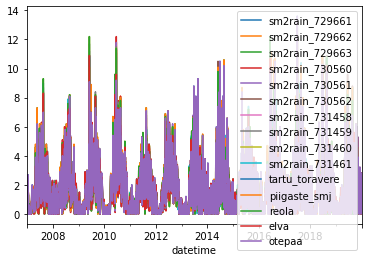

In [97]:
sm2rain_df_all.plot()

## SM2RAIN v1.4 location time indexed data selection

- SM2RAIN-ASCAT is indexed via lat lon and time, like the other gridded datasets


In [52]:
data_select = 'SM2RAIN-ASCAT_V_1.4'

sat_data[data_select]

{'how': 'yearly',
 'filepattern': 'SM2RAIN_ASCAT_0125_YYYY_v1.4.nc',
 'first': datetime.date(2007, 1, 1),
 'last': datetime.date(2020, 12, 31),
 'variable': 'Rainfall(Latitude, Longitude, time)'}

In [53]:
first = sat_data[data_select]['first']
fp = sat_data[data_select]['filepattern']
f1 = os.path.join(sat_base,  data_select, set_date_string(fp, datetime.date(2019, 8, 19)) )
print(f1)

ds = xr.open_dataset(f1)

R:\Des\satellite precipitation\SM2RAIN-ASCAT_V_1.4\SM2RAIN_ASCAT_0125_2019_v1.4.nc


In [54]:
ds.info()

xarray.Dataset {
dimensions:
	Latitude = 1801 ;
	Longitude = 3600 ;
	time = 365 ;

variables:
	datetime64[ns] Time(time) ;
		Time:long_name = Time of measurement ;
		Time:standard_name = Time ;
	float32 Longitude(Longitude) ;
		Longitude:long_name = location longitude ;
		Longitude:standard_name = Longitude ;
		Longitude:units = degrees_east ;
		Longitude:valid_range = [-180.  180.] ;
	float32 Latitude(Latitude) ;
		Latitude:long_name = location latitude ;
		Latitude:standard_name = Latitude ;
		Latitude:units = degrees_north ;
		Latitude:valid_range = [-90.  90.] ;
	float32 Rainfall(Latitude, Longitude, time) ;
		Rainfall:long_name = Daily rainfall in mm ;
		Rainfall:standard_name = Daily rainfall ;
		Rainfall:units = mm/day ;
	float32 Rainfall_noise(Latitude, Longitude, time) ;
		Rainfall_noise:long_name = Daily Rainfall (mm/day) noise based on the propagation of the soil moisture noise via error propagation method ;
		Rainfall_noise:standard_name = Daily rainfall noise ;
		Rainfall_

In [55]:
# firs twe need the stations, they are likely different
mask_lon = (ds.Longitude >= min_lon) & (ds.Longitude <= max_lon)
mask_lat = (ds.Latitude >= min_lat-0.1) & (ds.Latitude <= max_lat)

cropped_ds = ds.sel(time=1).where(mask_lon & mask_lat, drop=True)

cropped_ds.info()

xarray.Dataset {
dimensions:
	Latitude = 4 ;
	Longitude = 7 ;

variables:
	datetime64[ns] Time(Longitude, Latitude) ;
		Time:long_name = Time of measurement ;
		Time:standard_name = Time ;
	float32 Rainfall(Latitude, Longitude) ;
		Rainfall:long_name = Daily rainfall in mm ;
		Rainfall:standard_name = Daily rainfall ;
		Rainfall:units = mm/day ;
	float32 Rainfall_noise(Latitude, Longitude) ;
		Rainfall_noise:long_name = Daily Rainfall (mm/day) noise based on the propagation of the soil moisture noise via error propagation method ;
		Rainfall_noise:standard_name = Daily rainfall noise ;
		Rainfall_noise:units = mm/day ;
	float64 Conf_flag(Latitude, Longitude) ;
		Conf_flag:long_name = Confidence flag ;
		Conf_flag:flag_meanings = Low_quality_SM Topographic_complexity>30% Bad_surface_state_flag ;
		Conf_flag:flag_masks = [1. 2. 4.] ;
		Conf_flag:valid_range = [0. 7.] ;
	float64 ssf(Latitude, Longitude) ;
		ssf:long_name = surface state flag based on ERA5 soil temperature ;
		ssf:standard

In [56]:
cropped_ds

<xarray.Dataset>
Dimensions:         (Latitude: 4, Longitude: 7)
Coordinates:
  * Longitude       (Longitude) float32 26.4 26.5 26.6 26.7 26.8 26.9 27.0
  * Latitude        (Latitude) float32 58.0 58.1 58.2 58.3
Data variables:
    Time            (Longitude, Latitude) datetime64[ns] 2019-01-02 ... 2019-...
    Rainfall        (Latitude, Longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Rainfall_noise  (Latitude, Longitude) float32 0.1 0.1 0.1 ... 0.1 0.1 0.1
    Conf_flag       (Latitude, Longitude) float64 0.0 0.0 0.0 ... 1.0 1.0 1.0
    ssf             (Latitude, Longitude) float64 3.0 3.0 3.0 ... 3.0 3.0 3.0
Attributes:
    title:                       ASCAT Soil moisture-derived rainfall using S...
    creation_time:               07-Feb-2021 19:28:37
    creator_institution:         National Research Council  - Research Instit...
    creator_institution_e-mail:   idrologia@irpi.cnr.it
    calibration:                 Two different calibration has been performed...
    correction:                  A climatological adjustment using model data...
    Temporal_interval:           Jan-01-2019 to Dec-31-2019
    version:                     1.4
    Acknowledgements:            Global SM2RAIN project (contract n.EUM/CO/17...

In [113]:
# cropped_ds.sel(datetime='2007-01-01').lat.data
lats = cropped_ds.Latitude.data
lons = cropped_ds.Longitude.data

x = np.array([[x0, y0] for x0 in lons for y0 in lats])[:,0]
y = np.array([[x0, y0] for x0 in lons for y0 in lats])[:,1]

sm2rain14_stations = pd.DataFrame({'station': range(len(x)), 'lon': x, 'lat': y})
sm2rain14_stations['geometry'] = sm2rain14_stations.apply(lambda x: Point(x['lon'], x['lat']), axis=1)
sm2rain14_stations = gpd.GeoDataFrame(sm2rain14_stations, geometry='geometry', crs=4326)
sm2rain14_stations

,station,lon,lat,geometry
0,0,26.400000,58.000000,POINT (26.40000 58.00000)
1,1,26.400000,58.099998,POINT (26.40000 58.10000)
2,2,26.400000,58.200001,POINT (26.40000 58.20000)
3,3,26.400000,58.299999,POINT (26.40000 58.30000)
4,4,26.500000,58.000000,POINT (26.50000 58.00000)
5,5,26.500000,58.099998,POINT (26.50000 58.10000)
6,6,26.500000,58.200001,POINT (26.50000 58.20000)
7,7,26.500000,58.299999,POINT (26.50000 58.30000)
8,8,26.600000,58.000000,POINT (26.60000 58.00000)
9,9,26.600000,58.099998,POINT (26.60000 58.10000)


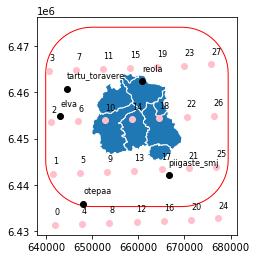

In [114]:
ax = clip_gdf.plot(facecolor='None', edgecolor='red')
catchment.plot(ax=ax, edgecolor='white', lw=1)
sub_stations.plot(color='black', ax=ax)
for idx, s in sub_stations.iterrows():
    plt.text(s['geometry'].x, s['geometry'].y,"{}\n".format(s['ascii_name']),size=8, color='black')
sm2rain14_stations.to_crs(3301).plot(color='pink', ax=ax)
for idx, s in sm2rain14_stations.to_crs(3301).iterrows():
    plt.text(s['geometry'].x, s['geometry'].y,"{}\n".format(s['station']),size=8, color='black')

In [117]:
first = sat_data[data_select]['first']
last = sat_data[data_select]['last']

annual_dfs = []

for yy in range(first.year, last.year+1):
    print(yy)
    fp = sat_data[data_select]['filepattern']
    f1 = os.path.join(sat_base,  data_select, set_date_string(fp, datetime.date(yy, 1, 1)) )
    print(f1)
    
    ds = xr.open_mfdataset(f1)

    catch_it = []

    for idx, row in sm2rain14_stations.iterrows():
        ts = ds.Rainfall.sel(Latitude=row['lat'], Longitude=row['lon'])
        # df = ts.to_dataframe()
        t_idx = pd.date_range(start=f'{yy}-01-01', end=f'{yy}-12-31', freq="D")
        df = pd.DataFrame({'datetime': t_idx, 'data': ts}).set_index('datetime')
        
        lat = np.round(row['lat'], decimals=3)
        lon = np.round(row['lon'], decimals=3)
        updated = f"sm2rain14_{ lat }_{ lon }"

        catch_it.append( df.rename(columns={ 'data': updated } ) )

    for idx, row in sub_stations.iterrows():
        ts = ds.Rainfall.sel(Latitude=row['latitude'], Longitude=row['longitude'], method='nearest')
        # df = ts.to_dataframe()
        t_idx = pd.date_range(start=f'{yy}-01-01', end=f'{yy}-12-31', freq="D")
        df = pd.DataFrame({'datetime': t_idx, 'data': ts}).set_index('datetime')
        catch_it.append( df.rename(columns={ 'data': row['ascii_name'] } ) )

    sm2rain14_df_year = pd.concat(catch_it, axis=1)
    annual_dfs.append(sm2rain14_df_year)

2007
R:\Des\satellite precipitation\SM2RAIN-ASCAT_V_1.4\SM2RAIN_ASCAT_0125_2007_v1.4.nc
2008
R:\Des\satellite precipitation\SM2RAIN-ASCAT_V_1.4\SM2RAIN_ASCAT_0125_2008_v1.4.nc
2009
R:\Des\satellite precipitation\SM2RAIN-ASCAT_V_1.4\SM2RAIN_ASCAT_0125_2009_v1.4.nc
2010
R:\Des\satellite precipitation\SM2RAIN-ASCAT_V_1.4\SM2RAIN_ASCAT_0125_2010_v1.4.nc
2011
R:\Des\satellite precipitation\SM2RAIN-ASCAT_V_1.4\SM2RAIN_ASCAT_0125_2011_v1.4.nc
2012
R:\Des\satellite precipitation\SM2RAIN-ASCAT_V_1.4\SM2RAIN_ASCAT_0125_2012_v1.4.nc
2013
R:\Des\satellite precipitation\SM2RAIN-ASCAT_V_1.4\SM2RAIN_ASCAT_0125_2013_v1.4.nc
2014
R:\Des\satellite precipitation\SM2RAIN-ASCAT_V_1.4\SM2RAIN_ASCAT_0125_2014_v1.4.nc
2015
R:\Des\satellite precipitation\SM2RAIN-ASCAT_V_1.4\SM2RAIN_ASCAT_0125_2015_v1.4.nc
2016
R:\Des\satellite precipitation\SM2RAIN-ASCAT_V_1.4\SM2RAIN_ASCAT_0125_2016_v1.4.nc
2017
R:\Des\satellite precipitation\SM2RAIN-ASCAT_V_1.4\SM2RAIN_ASCAT_0125_2017_v1.4.nc
2018
R:\Des\satellite precipitat

In [118]:
sm2rain14_df_all = pd.concat(annual_dfs, axis=0)

In [119]:
sm2rain14_df_all.sample(5)

,sm2rain14_58.0_26.4,sm2rain14_58.1_26.4,sm2rain14_58.2_26.4,sm2rain14_58.3_26.4,sm2rain14_58.0_26.5,sm2rain14_58.1_26.5,sm2rain14_58.2_26.5,sm2rain14_58.3_26.5,sm2rain14_58.0_26.6,sm2rain14_58.1_26.6,...,sm2rain14_58.3_26.9,sm2rain14_58.0_27.0,sm2rain14_58.1_27.0,sm2rain14_58.2_27.0,sm2rain14_58.3_27.0,tartu_toravere,piigaste_smj,reola,elva,otepaa
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-09,1.1,1.1,1.3,1.3,1.1,1.0,1.2,1.3,1.2,1.1,...,1.1,1.2,1.1,1.0,1.0,1.3,1.1,1.2,1.3,1.1
2014-06-17,3.9,4.4,4.6,4.3,3.9,4.4,4.6,4.7,3.8,4.3,...,4.9,2.9,3.2,3.8,4.3,4.7,4.1,5.0,4.6,3.9
2011-12-20,0.9,0.9,0.8,0.7,0.9,0.8,0.7,0.6,0.8,0.7,...,0.5,0.1,0.1,0.1,0.3,0.6,0.5,0.6,0.8,0.9
2008-10-30,3.8,3.6,3.4,3.5,3.8,3.6,3.4,3.5,3.8,3.6,...,3.7,3.8,3.8,3.7,3.7,3.5,3.6,3.5,3.4,3.8
2011-11-06,0.8,0.8,0.9,1.1,0.8,0.8,0.9,1.0,0.8,0.8,...,1.0,0.7,0.7,0.7,0.8,1.0,0.8,1.0,0.9,0.8


In [120]:
out_dir = data_select
out_file = 'SM2RAIN_ASCAT_0125_v1.4_extracted.csv'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

sm2rain14_df_all.to_csv(os.path.join(out_dir, out_file) )

sm2rain14_stations.to_file(os.path.join(out_dir, 'sm2rain14_stations.shp') )

<AxesSubplot:xlabel='datetime'>

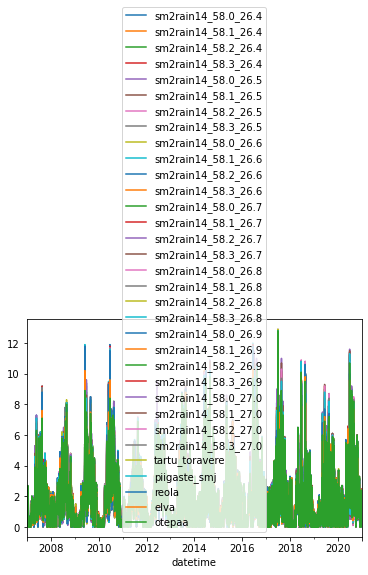

In [122]:
sm2rain14_df_all.plot()

## IMERG

- todo

In [76]:
data_select = 'IMERG'

sat_data[data_select]

{'how': 'daily',
 'filepattern': 'YYYY\\3B-DAY.MS.MRG.3IMERG.YYYYMMDD-S000000-E235959.V06.nc4',
 'first': datetime.date(2007, 1, 1),
 'last': datetime.date(2020, 12, 31),
 'variable': 'precipitationCal(time, lon, lat)'}

In [77]:
first = sat_data[data_select]['first']
fp = sat_data[data_select]['filepattern']
f1 = os.path.join(sat_base,  data_select, set_date_string(fp, first) )
print(f1)

ds = xr.open_mfdataset(f1)

R:\Des\satellite precipitation\IMERG\2007\3B-DAY.MS.MRG.3IMERG.20070101-S000000-E235959.V06.nc4


In [78]:
ds

<xarray.Dataset>
Dimensions:                    (lat: 1800, lon: 3600, nv: 2, time: 1)
Coordinates:
  * lon                        (lon) float32 -179.95 -179.84999 ... 179.95
  * lat                        (lat) float32 -89.95 -89.85 ... 89.95001
  * time                       (time) object 2007-01-01 00:00:00
Dimensions without coordinates: nv
Data variables:
    precipitationCal           (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    precipitationCal_cnt       (time, lon, lat) int8 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    precipitationCal_cnt_cond  (time, lon, lat) int8 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    HQprecipitation            (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    HQprecipitation_cnt        (time, lon, lat) int8 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    HQprecipitation_cnt_cond   (time, lon, lat) int8 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    randomError                (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    randomError_cnt            (time, lon, lat) int8 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    time_bnds                  (time, nv) object dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    BeginDate:       2007-01-01
    BeginTime:       00:00:00.000Z
    EndDate:         2007-01-01
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2007-01-01T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR.MS.MRG.3IMERG.20070101-S000000-E002959.0000.V06B....
    title:           GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 ...
    DOI:             10.5067/GPM/IMERGDF/DAY/06
    ProductionTime:  2019-06-28T14:06:36.671Z

In [79]:
mask_lon = (ds.lon >= min_lon) & (ds.lon <= max_lon-0.1)
mask_lat = (ds.lat >= min_lat) & (ds.lat <= max_lat)

In [80]:
cropped_ds = ds.where(mask_lon & mask_lat, drop=True)

In [81]:
cropped_ds

<xarray.Dataset>
Dimensions:                    (lat: 4, lon: 6, nv: 2, time: 1)
Coordinates:
  * lon                        (lon) float32 26.450008 26.55 ... 26.950008
  * lat                        (lat) float32 58.05 58.150005 58.249996 58.350002
  * time                       (time) object 2007-01-01 00:00:00
Dimensions without coordinates: nv
Data variables:
    precipitationCal           (time, lon, lat) float32 dask.array<chunksize=(1, 6, 4), meta=np.ndarray>
    precipitationCal_cnt       (time, lon, lat) float64 dask.array<chunksize=(1, 6, 4), meta=np.ndarray>
    precipitationCal_cnt_cond  (time, lon, lat) float64 dask.array<chunksize=(1, 6, 4), meta=np.ndarray>
    HQprecipitation            (time, lon, lat) float32 dask.array<chunksize=(1, 6, 4), meta=np.ndarray>
    HQprecipitation_cnt        (time, lon, lat) float64 dask.array<chunksize=(1, 6, 4), meta=np.ndarray>
    HQprecipitation_cnt_cond   (time, lon, lat) float64 dask.array<chunksize=(1, 6, 4), meta=np.ndarray>
    randomError                (time, lon, lat) float32 dask.array<chunksize=(1, 6, 4), meta=np.ndarray>
    randomError_cnt            (time, lon, lat) float64 dask.array<chunksize=(1, 6, 4), meta=np.ndarray>
    time_bnds                  (time, nv, lon, lat) object dask.array<chunksize=(1, 2, 6, 4), meta=np.ndarray>
Attributes:
    BeginDate:       2007-01-01
    BeginTime:       00:00:00.000Z
    EndDate:         2007-01-01
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2007-01-01T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR.MS.MRG.3IMERG.20070101-S000000-E002959.0000.V06B....
    title:           GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 ...
    DOI:             10.5067/GPM/IMERGDF/DAY/06
    ProductionTime:  2019-06-28T14:06:36.671Z

In [82]:
lats = cropped_ds.sel(time='2007-01-01').lat.data
lons = cropped_ds.sel(time='2007-01-01').lon.data

x = np.array([[x0, y0] for x0 in lons for y0 in lats])[:,0]
y = np.array([[x0, y0] for x0 in lons for y0 in lats])[:,1]

imerg_stations = pd.DataFrame({'station': range(len(x)), 'lon': x, 'lat': y})
imerg_stations['geometry'] = imerg_stations.apply(lambda x: Point(x['lon'], x['lat']), axis=1)
imerg_stations = gpd.GeoDataFrame(imerg_stations, geometry='geometry', crs=4326)
imerg_stations

,station,lon,lat,geometry
0,0,26.450008,58.049999,POINT (26.45001 58.05000)
1,1,26.450008,58.150005,POINT (26.45001 58.15001)
2,2,26.450008,58.249996,POINT (26.45001 58.25000)
3,3,26.450008,58.350002,POINT (26.45001 58.35000)
4,4,26.549999,58.049999,POINT (26.55000 58.05000)
5,5,26.549999,58.150005,POINT (26.55000 58.15001)
6,6,26.549999,58.249996,POINT (26.55000 58.25000)
7,7,26.549999,58.350002,POINT (26.55000 58.35000)
8,8,26.650005,58.049999,POINT (26.65001 58.05000)
9,9,26.650005,58.150005,POINT (26.65001 58.15001)


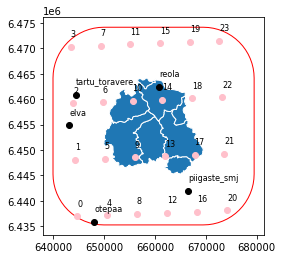

In [83]:
ax = clip_gdf.plot(facecolor='None', edgecolor='red')
catchment.plot(ax=ax, edgecolor='white', lw=1)
sub_stations.plot(color='black', ax=ax)
for idx, s in sub_stations.iterrows():
    plt.text(s['geometry'].x, s['geometry'].y,"{}\n".format(s['ascii_name']),size=8, color='black')
imerg_stations.to_crs(3301).plot(color='pink', ax=ax)
for idx, s in imerg_stations.to_crs(3301).iterrows():
    plt.text(s['geometry'].x, s['geometry'].y,"{}\n".format(s['station']),size=8, color='black')

In [ ]:
import glob
import toolz

f1 = os.path.join(sat_base,  data_select, set_date_string_wglob(fp, datetime.date(2007, 1, 1), glob_str='YYYYMMDD') )

one_year = glob.glob(f1)
one_year = sorted(one_year)

for part in toolz.partition_all(20, one_year):
    print(part)
    ds = xr.open_mfdataset(part)
    ds.close()
    del(ds)

In [85]:
%%time

first = sat_data[data_select]['first']
last = sat_data[data_select]['last']

annual_dfs = []

    
for yy in range(first.year, last.year+1):
    # print(yy)
    fp = sat_data[data_select]['filepattern']
    f1 = os.path.join(sat_base,  data_select, set_date_string_wglob(fp, datetime.date(yy, 1, 1), glob_str='YYYYMMDD') )
    print(f1)
    counter = 0
    
    one_year = glob.glob(f1)
    one_year = sorted(one_year)
    
    count_all = len(one_year)
    catch_it = []
    
    for part in toolz.partition_all(20, one_year):
        counter = counter + len(part)
        print(f"working on {counter} out of {count_all} ({yy})")
        ds = xr.open_mfdataset(part)
        
        parallel_merge = []
              
        for idx, row in imerg_stations.iterrows():
            ts = ds.precipitationCal.sel(lat=row['lat'], lon=row['lon'])
            df = ts.to_dataframe()
            df['date'] = df.apply(lambda r: datetime.date ( r.name.year, r.name.month, r.name.day ), axis=1)
            df = df.set_index('date', drop=True, verify_integrity=True)

            lat = np.round(row['lat'], decimals=3)
            lon = np.round(row['lon'], decimals=3)
            updated = f"imerg_{ lat }_{ lon }"
            
            parallel_merge.append( df.drop(columns=['lon', 'lat']).rename(columns={ 'precipitationCal': updated } ) )

        for idx, row in sub_stations.iterrows():
            ts = ds.precipitationCal.sel(lat=row['latitude'], lon=row['longitude'], method='nearest')
            df = ts.to_dataframe()
            df['date'] = df.apply(lambda r: datetime.date ( r.name.year, r.name.month, r.name.day ), axis=1)
            df = df.set_index('date', drop=True, verify_integrity=True)
            parallel_merge.append( df.drop(columns=['lon', 'lat']).rename(columns={ 'precipitationCal': row['ascii_name'] } ) )
        
        catch_it.append(pd.concat(parallel_merge, axis=1))

    imerg_df_year = pd.concat(catch_it, axis=0)
    annual_dfs.append(imerg_df_year)

R:\Des\satellite precipitation\IMERG\2007\3B-DAY.MS.MRG.3IMERG.*-S000000-E235959.V06.nc4
working on 20 out of 365 (2007)
working on 40 out of 365 (2007)
working on 60 out of 365 (2007)
working on 80 out of 365 (2007)
working on 100 out of 365 (2007)
working on 120 out of 365 (2007)
working on 140 out of 365 (2007)
working on 160 out of 365 (2007)
working on 180 out of 365 (2007)
working on 200 out of 365 (2007)
working on 220 out of 365 (2007)
working on 240 out of 365 (2007)
working on 260 out of 365 (2007)
working on 280 out of 365 (2007)
working on 300 out of 365 (2007)
working on 320 out of 365 (2007)
working on 340 out of 365 (2007)
working on 360 out of 365 (2007)
working on 365 out of 365 (2007)
R:\Des\satellite precipitation\IMERG\2008\3B-DAY.MS.MRG.3IMERG.*-S000000-E235959.V06.nc4
working on 20 out of 366 (2008)
working on 40 out of 366 (2008)
working on 60 out of 366 (2008)
working on 80 out of 366 (2008)
working on 100 out of 366 (2008)
working on 120 out of 366 (2008)
worki

In [86]:
imerg_df_year

,imerg_58.05_26.45,imerg_58.15_26.45,imerg_58.25_26.45,imerg_58.35_26.45,imerg_58.05_26.55,imerg_58.15_26.55,imerg_58.25_26.55,imerg_58.35_26.55,imerg_58.05_26.65,imerg_58.15_26.65,...,imerg_58.35_26.85,imerg_58.05_26.95,imerg_58.15_26.95,imerg_58.25_26.95,imerg_58.35_26.95,tartu_toravere,piigaste_smj,reola,elva,otepaa
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1.667567,0.067027,0.056202,0.133689,1.668255,0.046000,0.060527,0.152052,0.107271,1.439710,...,0.088527,0.802419,0.369987,0.256184,0.091741,0.056202,0.874122,0.181123,0.056202,1.668255
2020-01-02,0.572640,0.004384,0.015591,0.036357,1.235853,0.011558,0.058633,0.072761,0.047708,2.037968,...,0.017796,0.081405,0.045960,0.012328,0.009773,0.015591,0.132078,0.037713,0.015591,1.235853
2020-01-03,0.071402,0.158355,0.376265,0.368087,0.040140,0.177869,0.372323,0.371156,0.556263,0.030284,...,0.102234,1.079595,0.713063,0.462955,0.753787,0.376265,0.406068,0.117838,0.376265,0.040140
2020-01-04,2.437345,7.202121,1.487669,0.498043,1.744619,4.686178,1.812445,0.500584,9.259398,1.129458,...,5.360229,6.973598,5.451382,7.518758,5.834227,1.487669,6.046777,2.495800,1.487669,1.744619
2020-01-05,3.261457,3.412907,1.935920,2.716637,3.042477,2.329982,1.828767,2.805837,1.381867,2.524052,...,0.672648,0.895066,1.407438,1.361405,0.526132,1.935920,1.036681,2.194218,1.935920,3.042477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,2.980100,2.456119,0.913401,0.221399,2.563019,2.020030,0.649986,0.107294,1.740576,1.572017,...,3.398187,1.641646,1.511318,1.151702,2.266433,0.913401,1.056259,2.248594,0.913401,2.563019
2020-12-28,4.290425,5.179302,4.673802,5.087197,4.377844,4.888494,4.565474,5.125540,4.291279,4.811283,...,6.881586,4.205884,4.898214,10.103092,8.918489,4.673802,3.276297,4.759685,4.673802,4.377844
2020-12-29,2.994335,2.599586,3.758591,5.357327,2.263190,2.930790,4.537953,5.537376,2.896916,3.489687,...,2.408414,2.981832,3.102094,2.828818,2.961826,3.758591,1.143236,2.841537,3.758591,2.263190


In [87]:
imerg_df_all = pd.concat(annual_dfs, axis=0)

<AxesSubplot:xlabel='date'>

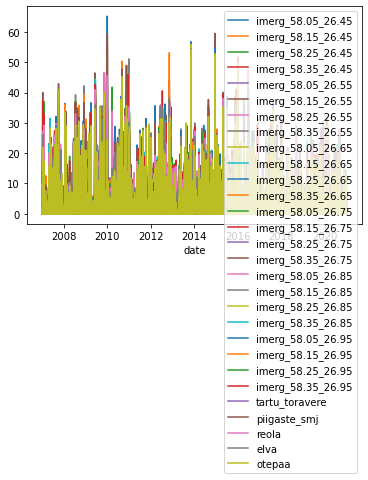

In [90]:
imerg_df_all.plot()

In [88]:
len(annual_dfs[0].index)

365

In [89]:
len(imerg_df_all[['imerg_58.25_26.45','tartu_toravere']].index)

5113

In [43]:
(2020-2007)*365

4745

In [91]:
out_dir = data_select
out_file = '3B-DAY.MS.MRG.3IMERG.E235959.V06.nc4_extracted.csv'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

imerg_df_all.to_csv(os.path.join(out_dir, out_file) )

imerg_stations.to_file(os.path.join(out_dir, 'imerg_stations.shp') )

<AxesSubplot:xlabel='date'>

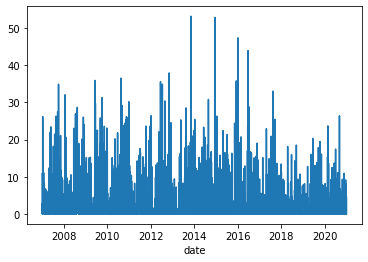

In [92]:
imerg_df_all['tartu_toravere'].plot()

## Single day map from SM2RAIN V1.4 21st August of 2019

In [59]:
data_select = 'SM2RAIN-ASCAT_V_1.4'

sat_data[data_select]

first = sat_data[data_select]['first']
fp = sat_data[data_select]['filepattern']
f1 = os.path.join(sat_base,  data_select, set_date_string(fp, datetime.date(2019, 8, 19)) )
print(f1)

ds = xr.open_dataset(f1)

# firs twe need the stations, they are likely different
mask_lon = (ds.Longitude >= min_lon) & (ds.Longitude <= max_lon)
mask_lat = (ds.Latitude >= min_lat-0.1) & (ds.Latitude <= max_lat)

cropped_ds = ds.where(mask_lon & mask_lat, drop=True)

cropped_ds.info()

R:\Des\satellite precipitation\SM2RAIN-ASCAT_V_1.4\SM2RAIN_ASCAT_0125_2019_v1.4.nc
xarray.Dataset {
dimensions:
	Latitude = 4 ;
	Longitude = 7 ;
	time = 365 ;

variables:
	datetime64[ns] Time(time, Longitude, Latitude) ;
		Time:long_name = Time of measurement ;
		Time:standard_name = Time ;
	float32 Rainfall(Latitude, Longitude, time) ;
		Rainfall:long_name = Daily rainfall in mm ;
		Rainfall:standard_name = Daily rainfall ;
		Rainfall:units = mm/day ;
	float32 Rainfall_noise(Latitude, Longitude, time) ;
		Rainfall_noise:long_name = Daily Rainfall (mm/day) noise based on the propagation of the soil moisture noise via error propagation method ;
		Rainfall_noise:standard_name = Daily rainfall noise ;
		Rainfall_noise:units = mm/day ;
	float64 Conf_flag(Latitude, Longitude) ;
		Conf_flag:long_name = Confidence flag ;
		Conf_flag:flag_meanings = Low_quality_SM Topographic_complexity>30% Bad_surface_state_flag ;
		Conf_flag:flag_masks = [1. 2. 4.] ;
		Conf_flag:valid_range = [0. 7.] ;
	floa

In [70]:
t_idx = pd.date_range(start=f'2019-01-01', end=f'2019-12-31', freq="D")
for idx, ts in enumerate(t_idx):
    if ts == datetime.date(2019, 8, 19):
        print(idx)

230


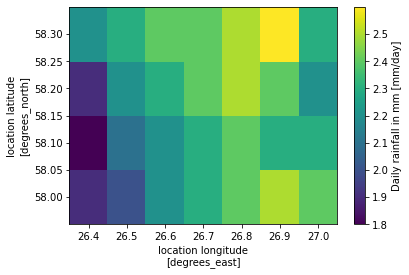

In [72]:
cropped_ds.Rainfall.sel(time=230).plot()

In [73]:
cropped_ds.Rainfall.sel(time=230).to_netcdf('SM2RAIN_V1.4_21st_August_2019.nc')

## ERA5

In [12]:
data_select = 'ERA5'

sat_data[data_select]

first = sat_data[data_select]['first']
fp = sat_data[data_select]['filepattern']
f1 = os.path.join(sat_base,  data_select, set_date_string(fp, first) )
print(f1)

ds = xr.open_mfdataset(f1)

ds

R:\Des\satellite precipitation\ERA5\2007\gpcp_v01r03_daily_d20070101.nc


<xarray.Dataset>
Dimensions:      (latitude: 180, longitude: 360, nv: 2, time: 1)
Coordinates:
  * latitude     (latitude) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
  * longitude    (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * time         (time) object 2007-01-01 00:00:00
Dimensions without coordinates: nv
Data variables:
    lat_bounds   (latitude, nv) float32 dask.array<chunksize=(180, 2), meta=np.ndarray>
    lon_bounds   (longitude, nv) float32 dask.array<chunksize=(360, 2), meta=np.ndarray>
    time_bounds  (time, nv) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    precip       (time, latitude, longitude) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.6, ACDD 1.3
    title:                      Global Precipitation Climatatology Project (G...
    source:                     /data1/GPCP_CDR/GPCP_Output/1DD//bin/200701/s...
    references:                 Huffman et al. 1997, http://dx.doi.org/10.117...
    history:                    1) 2017-05-30T17:05:52Z, Dr. Jian-Jian Wang, ...
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0, NOAA ...
    standard_name_vocabulary:   CF Standard Name Table (v41, 22 February 2017)
    id:                         200701/gpcp_v01r03_daily_d20070101_c20170530.nc
    naming_authority:           gov.noaa.ncdc
    date_created:               2017-05-30T17:05:52Z
    license:                    No constraints on data access or use.
    summary:                    Global Precipitation Climatology Project (GPC...
    keywords:                   EARTH SCIENCE > ATMOSPHERE > PRECIPITATION > ...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Ea...
    cdm_data_type:              Grid
    project:                    GPCP > Global Precipitation Climatology Project
    processing_level:           NASA Level 3
    creator_name:               Dr. Jian-Jian Wang
    creator_email:              jjwang@umd.edu
    institution:                ACADEMIC > UMD/ESSIC > Earth System Science I...
    publisher_name:             NOAA National Centers for Environmental Infor...
    publisher_email:            jjwang@umd.edu
    publisher_url:              https://www.ncei.noaa.gov
    geospatial_lat_min:         -90.0
    geospatial_lat_max:         90.0
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  1 degree
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  1 degree
    time_coverage_start:        2007-01-01T00:00:00Z
    time_coverage_end:          2007-01-01T23:59:59Z
    time_coverage_duration:     P1D
    contributor_name:           Robert Adler, Jian-Jian Wang
    contributor_role:           principalInvestigator, processor and custodian
    acknowledgment:             This project was supported in part by a grant...
    cdr_program:                NOAA Climate Data Record Program for satellit...
    cdr_variable:               precipitation
    metadata_link:              gov.noaa.ncdc:XXXXX
    product_version:            v01r03
    platform:                   GOES (Geostationary Operational Environmental...
    sensor:                     Imager, AIRS > Atmospheric Infrared Sounder, ...
    spatial_resolution:         1 degree
    comment:                    Processing computer: eagle2.umd.edu

In [13]:
mask_lon = (ds.longitude >= min_lon-0.5) & (ds.longitude <= max_lon+0.5)
mask_lat = (ds.latitude >= min_lat-0.5) & (ds.latitude <= max_lat+0.5)

cropped_ds = ds.where(mask_lon & mask_lat, drop=True)

cropped_ds

<xarray.Dataset>
Dimensions:      (latitude: 1, longitude: 2, nv: 2, time: 1)
Coordinates:
  * latitude     (latitude) float32 58.0
  * longitude    (longitude) float32 26.0 27.0
  * time         (time) object 2007-01-01 00:00:00
Dimensions without coordinates: nv
Data variables:
    lat_bounds   (latitude, nv, longitude) float32 dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
    lon_bounds   (longitude, nv, latitude) float32 dask.array<chunksize=(2, 2, 1), meta=np.ndarray>
    time_bounds  (time, nv, longitude, latitude) object dask.array<chunksize=(1, 2, 2, 1), meta=np.ndarray>
    precip       (time, latitude, longitude) float32 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.6, ACDD 1.3
    title:                      Global Precipitation Climatatology Project (G...
    source:                     /data1/GPCP_CDR/GPCP_Output/1DD//bin/200701/s...
    references:                 Huffman et al. 1997, http://dx.doi.org/10.117...
    history:                    1) 2017-05-30T17:05:52Z, Dr. Jian-Jian Wang, ...
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0, NOAA ...
    standard_name_vocabulary:   CF Standard Name Table (v41, 22 February 2017)
    id:                         200701/gpcp_v01r03_daily_d20070101_c20170530.nc
    naming_authority:           gov.noaa.ncdc
    date_created:               2017-05-30T17:05:52Z
    license:                    No constraints on data access or use.
    summary:                    Global Precipitation Climatology Project (GPC...
    keywords:                   EARTH SCIENCE > ATMOSPHERE > PRECIPITATION > ...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Ea...
    cdm_data_type:              Grid
    project:                    GPCP > Global Precipitation Climatology Project
    processing_level:           NASA Level 3
    creator_name:               Dr. Jian-Jian Wang
    creator_email:              jjwang@umd.edu
    institution:                ACADEMIC > UMD/ESSIC > Earth System Science I...
    publisher_name:             NOAA National Centers for Environmental Infor...
    publisher_email:            jjwang@umd.edu
    publisher_url:              https://www.ncei.noaa.gov
    geospatial_lat_min:         -90.0
    geospatial_lat_max:         90.0
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  1 degree
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  1 degree
    time_coverage_start:        2007-01-01T00:00:00Z
    time_coverage_end:          2007-01-01T23:59:59Z
    time_coverage_duration:     P1D
    contributor_name:           Robert Adler, Jian-Jian Wang
    contributor_role:           principalInvestigator, processor and custodian
    acknowledgment:             This project was supported in part by a grant...
    cdr_program:                NOAA Climate Data Record Program for satellit...
    cdr_variable:               precipitation
    metadata_link:              gov.noaa.ncdc:XXXXX
    product_version:            v01r03
    platform:                   GOES (Geostationary Operational Environmental...
    sensor:                     Imager, AIRS > Atmospheric Infrared Sounder, ...
    spatial_resolution:         1 degree
    comment:                    Processing computer: eagle2.umd.edu

In [14]:
latitudes = cropped_ds.sel(time='2007-01-01').latitude.data
longitudes = cropped_ds.sel(time='2007-01-01').longitude.data

x = np.array([[x0, y0] for x0 in longitudes for y0 in latitudes])[:,0]
y = np.array([[x0, y0] for x0 in longitudes for y0 in latitudes])[:,1]

era5_stations = pd.DataFrame({'station': range(len(x)), 'longitude': x, 'latitude': y})
era5_stations['geometry'] = era5_stations.apply(lambda x: Point(x['longitude'], x['latitude']), axis=1)
era5_stations = gpd.GeoDataFrame(era5_stations, geometry='geometry', crs=4326)
era5_stations

,station,longitude,latitude,geometry
0,0,26.0,58.0,POINT (26.00000 58.00000)
1,1,27.0,58.0,POINT (27.00000 58.00000)


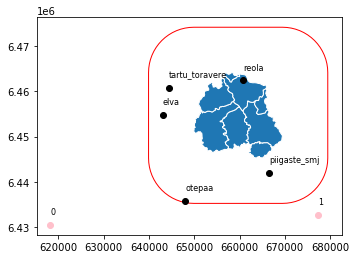

In [15]:
ax = clip_gdf.plot(facecolor='None', edgecolor='red')
catchment.plot(ax=ax, edgecolor='white', lw=1)
sub_stations.plot(color='black', ax=ax)
for idx, s in sub_stations.iterrows():
    plt.text(s['geometry'].x, s['geometry'].y,"{}\n".format(s['ascii_name']),size=8, color='black')
era5_stations.to_crs(3301).plot(color='pink', ax=ax)
for idx, s in era5_stations.to_crs(3301).iterrows():
    plt.text(s['geometry'].x, s['geometry'].y,"{}\n".format(s['station']),size=8, color='black')


In [16]:
first = sat_data['ERA5']['first']
last = sat_data['ERA5']['last']

In [17]:
annual_dfs = []

for yy in range(first.year, last.year+1):
    print(yy)
    fp = sat_data['ERA5']['filepattern']
    f1 = os.path.join(sat_base,  'ERA5', set_date_string_wglob(fp, datetime.date(yy, 1, 1), glob_str='YYYYMMDD') )
    print(f1)
    
    ds = xr.open_mfdataset(f1)

    catch_it = []

    for idx, row in era5_stations.iterrows():
        ts = ds.precip.sel(latitude=row['latitude'], longitude=row['longitude'])
        df = ts.to_dataframe()
        df['date'] = df.apply(lambda r: datetime.date ( r.name.year, r.name.month, r.name.day ), axis=1)
        df = df.set_index('date', drop=True, verify_integrity=True)
        catch_it.append( df.drop(columns=['longitude', 'latitude']).rename(columns={ 'precip': f"era5_{row['latitude']}_{row['longitude']}" } ) )

    for idx, row in sub_stations.iterrows():
        ts = ds.precip.sel(latitude=row['latitude'], longitude=row['longitude'], method='nearest')
        df = ts.to_dataframe()
        df['date'] = df.apply(lambda r: datetime.date ( r.name.year, r.name.month, r.name.day ), axis=1)
        df = df.set_index('date', drop=True, verify_integrity=True)
        catch_it.append( df.drop(columns=['longitude', 'latitude']).rename(columns={ 'precip': row['ascii_name'] } ) )

    era5_df_year = pd.concat(catch_it, axis=1)
    annual_dfs.append(era5_df_year)

2007
R:\Des\satellite precipitation\ERA5\2007\gpcp_v01r03_daily_d*.nc
2008
R:\Des\satellite precipitation\ERA5\2008\gpcp_v01r03_daily_d*.nc
2009
R:\Des\satellite precipitation\ERA5\2009\gpcp_v01r03_daily_d*.nc
2010
R:\Des\satellite precipitation\ERA5\2010\gpcp_v01r03_daily_d*.nc
2011
R:\Des\satellite precipitation\ERA5\2011\gpcp_v01r03_daily_d*.nc
2012
R:\Des\satellite precipitation\ERA5\2012\gpcp_v01r03_daily_d*.nc
2013
R:\Des\satellite precipitation\ERA5\2013\gpcp_v01r03_daily_d*.nc
2014
R:\Des\satellite precipitation\ERA5\2014\gpcp_v01r03_daily_d*.nc
2015
R:\Des\satellite precipitation\ERA5\2015\gpcp_v01r03_daily_d*.nc
2016
R:\Des\satellite precipitation\ERA5\2016\gpcp_v01r03_daily_d*.nc
2017
R:\Des\satellite precipitation\ERA5\2017\gpcp_v01r03_daily_d*.nc
2018
R:\Des\satellite precipitation\ERA5\2018\gpcp_v01r03_daily_d*.nc
2019
R:\Des\satellite precipitation\ERA5\2019\gpcp_v01r03_daily_d*.nc
2020
R:\Des\satellite precipitation\ERA5\2020\gpcp_v01r03_daily_d*.nc


In [18]:
era5_df_all = pd.concat(annual_dfs, axis=0)

In [22]:
era5_df_all.loc[ era5_df_all['era5_58.0_26.0'] > 0].sample(3)

,era5_58.0_26.0,era5_58.0_27.0,tartu_toravere,piigaste_smj,reola,elva,otepaa
time,,,,,,,
2009-08-16 00:00:00,0.478310,1.155342,0.478310,1.155342,1.155342,0.478310,1.155342
2013-01-04 00:00:00,5.603715,5.784315,5.603715,5.784315,5.784315,5.603715,5.784315
2007-07-07 00:00:00,3.060931,4.148426,3.060931,4.148426,4.148426,3.060931,4.148426


In [24]:
era5_df_all['date'] = era5_df_all.apply(lambda r: datetime.date ( r.name.year, r.name.month, r.name.day ), axis=1)
era5_df_all = era5_df_all.set_index('date', drop=True, verify_integrity=True)

<AxesSubplot:xlabel='date'>

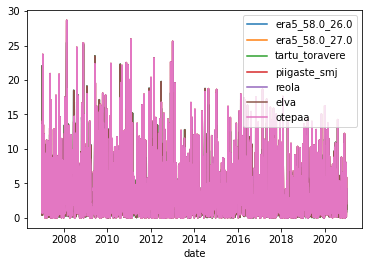

In [25]:
era5_df_all.loc[ era5_df_all['era5_58.0_26.0'] > 0].plot()

In [26]:
out_dir = data_select
out_file = 'era5_gpcp_v01r03_daily_d_extracted.csv'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

era5_df_all.to_csv(os.path.join(out_dir, out_file) )

era5_stations.to_file(os.path.join(out_dir, 'era5_stations.shp') )